# Model Visualization


In [86]:
%matplotlib inline
import copy
from itertools import product
import time
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mdp_lib.domains.gridworld import GridWorld
from planninginbeliefmodel import PlanningInObserverBeliefModel
from mdp_lib.domains.gridworldvis import visualize_trajectory, plot_text
from task import mdp_codes, mdp_params
from mdp_lib.util import sample_prob_dict
from util import mdp_to_feature_belief

model_obs_judgments = pd.read_pickle('./cached_values/model_obs_judgments.pkl')

# Plotting Doing (top row) versus Showing (bottom row) demonstrations

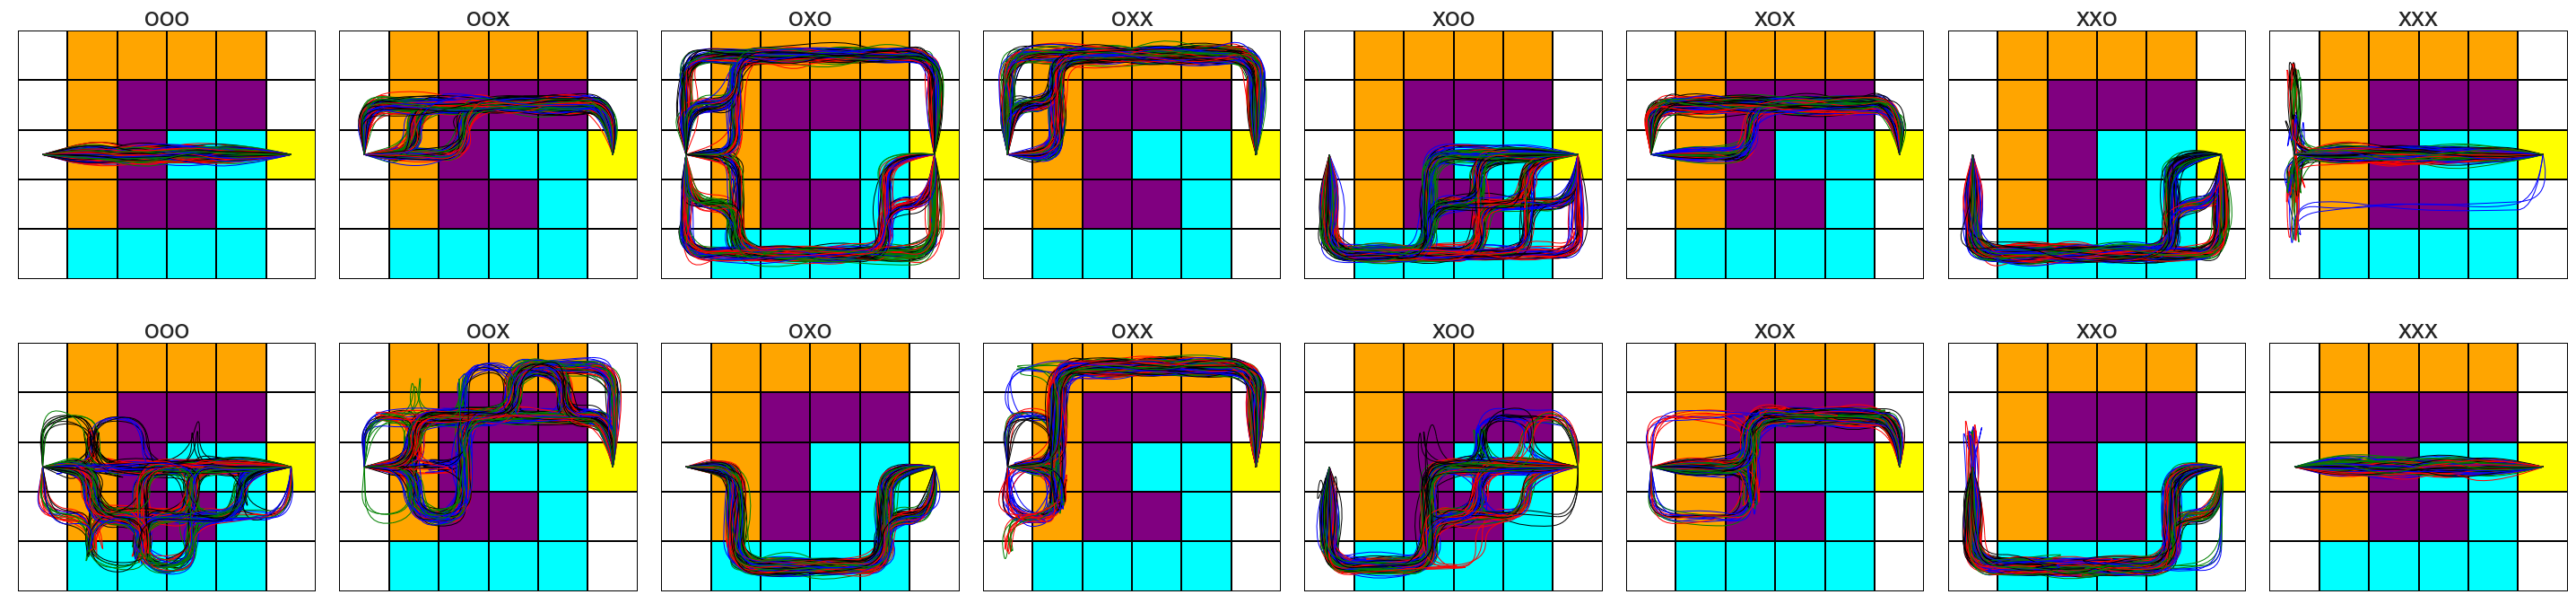

In [28]:
fig, axes = plt.subplots(2, 8, figsize=(40, 10))

only_obs_judg = model_obs_judgments[model_obs_judgments['observer'] == 'naive']
gw = GridWorld(**mdp_params[0])

colors = ['r','b','k','g']
for (dtype, rf), block in only_obs_judg.groupby(['demonstrator', 'rf']):
    ax = axes[['doing', 'showing'].index(dtype)][mdp_codes.index(rf)]
    gw.plot(ax=ax, feature_colors={'o':'orange', 'p':'purple', 'c':'cyan'})
    
    ti = 0
    for _, row in block.iterrows():
        if row['demonstrator'] == 'showing':
            traj = row['traj'][:-1]
        else:
            traj = row['traj']
        visualize_trajectory(axis=ax, traj=traj, 
                             color=colors[ti % len(colors)])
        ti += 1
    ax.set_title(rf, fontsize=30)
plt.tight_layout()

# Demonstrator x Observer Correct Probability
This figure plots amount of probablity mass placed on the correct reward for a color (e.g. safe or dangerous) for each of the demonstrator and observer combinations.

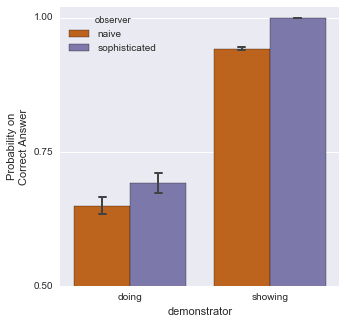

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
g = sns.barplot(data=model_obs_judgments,
                y='correct_prob', x='demonstrator',
                order=['doing', 'showing'],
                hue='observer', hue_order=['naive', 'sophisticated'],
                palette=sns.color_palette("Dark2")[1:],
                capsize=.05, errwidth=2, ax=ax)
plt.ylim(.5, 1.02)
g.set(yticks=[.5, .75, 1.0])
_ = ax.set_ylabel('Probability on\nCorrect Answer')

# Beliefs over time
This plot compares the evolution of beliefs over time between the two observer interpretation models.

In [126]:
belief_trajs = model_obs_judgments[['demonstrator', 'rf', 'traj',
                                    'observer', 'belief_traj', ]]
belief_trajs.traj = belief_trajs.traj.apply(tuple)
belief_trajs = belief_trajs.drop_duplicates(['demonstrator', 'rf', 'traj', 'observer'])
traj_block = belief_trajs[(belief_trajs.rf == 'oox') & 
                          (belief_trajs.demonstrator == 'showing')]
wtraj = traj_block.traj.iloc[0]
traj_block = traj_block[traj_block.traj == wtraj]
obs_b = traj_block[traj_block.observer == 'naive'].iloc[0]['belief_traj']
sobs_b = traj_block[traj_block.observer == 'sophisticated'].iloc[0]['belief_traj']

forder = ['orange', 'purple', 'cyan']
obs_b = pd.DataFrame([mdp_to_feature_belief(b, mdp_codes, forder) for b in obs_b])
obs_b['step'] = obs_b.index
obs_b['observer'] = 'naive'
sobs_b = pd.DataFrame([mdp_to_feature_belief(b, mdp_codes, forder) for b in sobs_b])
sobs_b['step'] = sobs_b.index
sobs_b['observer'] = 'sophisticated'

b_trajs = pd.concat([obs_b, sobs_b])
b_trajs = pd.melt(b_trajs, id_vars=['step', 'observer'], 
                  value_vars=['cyan', 'orange', 'purple'],
                  value_name='exp_safe', var_name='color')

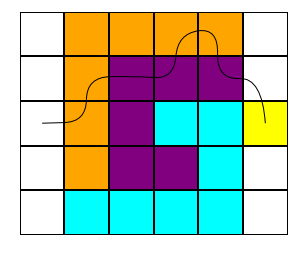

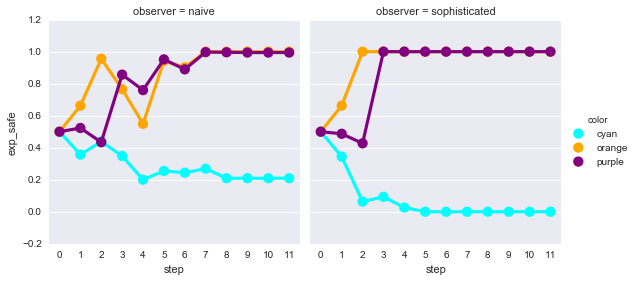

In [127]:
ax = gw.plot(feature_colors={'o': 'orange', 'p': 'purple', 'c': 'cyan'})
visualize_trajectory(axis=ax, traj=wtraj[:-1])
sns.factorplot(data=b_trajs, x='step', y='exp_safe',
               hue='color', 
               palette={'cyan':'cyan', 'orange':'orange', 'purple':'purple'},
               col='observer', col_order=['naive', 'sophisticated'])